# Imports

In [11]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint
import requests
from io import BytesIO, StringIO
import contextily as ctx
from IPython.display import HTML, display, IFrame
import osmnx as ox
import osmium
from osm_runner import Runner
import regex as re
import unicodedata
from zipfile import ZipFile
from urllib.request import urlopen

# Data

In [24]:
# get green areas
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt', 
                          sep ="|", 
                          encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                 'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                'Daily average of people in influence area': 'daily_avg_people',
                                                                'Number of buildings in influence area' : 'no_of_buildings',
                                                                'Number of families in influence area': 'no_of_families',
                                                                'Number of people resident in influence area' : 'no_of_people_resident'
                                                                })

green_areas.shape, green_areas.dtypes

((128, 14),
 Green_Zone_name               object
 no_of_museums                  int64
 no_of_parking_lots             int64
 no_of_tourist_attractions      int64
 gz_daily_avg_demand          float64
 Resident                       int64
 daily_avg_people             float64
 no_of_buildings                int64
 no_of_families                 int64
 no_of_people_resident          int64
 perc_senior_pop              float64
 perc_pop_until_19_yo         float64
 POINT_X                      float64
 POINT_Y                      float64
 dtype: object)

In [25]:
res_green_areas = green_areas[green_areas.Resident == 1]

In [13]:
# get parish code poly
# url = 'http://mapas.dgterritorio.pt/ATOM-download/CAOP-Cont/Cont_AAD_CAOP2020.zip'
path = 'map_data/Cont_AAD_CAOP2020'
parishes = gpd.read_file(path)
parishes.shape

(3223, 9)

# Get Polygons

In [22]:
# make latlng readable for OSM request
res_green_areas['latlng'] = res_green_areas.apply(lambda x: (x.POINT_Y, x.POINT_X), axis=1)

def get_parks(df):
    suggestions = pd.DataFrame()
    tags = {'leisure':True}
    for c, row in df.iterrows():
        center_point = row.latlng
        park = ox.geometries.geometries_from_point(center_point, 
                                                           tags=tags, 
                                                           dist=50)
        park['match'] = c # relate the findings to the dfs index (id)
        suggestions = pd.concat([suggestions, park])
        
    return suggestions

parks = get_parks(res_green_areas)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
parks.to_csv('map_data/parks.csv')

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# group the findings by the first finding
by_match = parks.groupby('match').first() # the first one seems to be the park
# merge the df with the matched 'parks' from the OSM request
res_green_areas = res_green_areas.merge(by_match['geometry'], how='left', left_index=True, right_index=True).sort_index()
res_green_areas.head()

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Green_Zone_name,no_of_museums,no_of_parking_lots,no_of_tourist_attractions,gz_daily_avg_demand,Resident,daily_avg_people,no_of_buildings,no_of_families,no_of_people_resident,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,geometry
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001,"POLYGON ((-8.68544 41.16198, -8.68570 41.16189..."
3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674,"POLYGON ((-9.20107 38.69706, -9.19972 38.69729..."
5,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294,"MULTIPOLYGON (((-9.15553 38.75406, -9.15551 38..."
7,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,1,17235.051457,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757,"POLYGON ((-9.13620 38.73734, -9.13619 38.73730..."
9,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,1,7104.740926,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062,"POLYGON ((-9.15689 38.72940, -9.15710 38.72929..."


In [27]:
# turn into geo df
geo_res_green_areas = gpd.GeoDataFrame(res_green_areas, geometry=res_green_areas.geometry)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# res_green_areas

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Merging

In [33]:
joint_gpd = gpd.sjoin(geo_res_green_areas, parishes, how="inner", op='intersects')
joint_gpd

<ipython-input-33-4cb2246c4bf5>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3763

  joint_gpd = gpd.sjoin(geo_res_green_areas, parishes, how="inner", op='intersects')


,Green_Zone_name,no_of_museums,no_of_parking_lots,no_of_tourist_attractions,gz_daily_avg_demand,Resident,daily_avg_people,no_of_buildings,no_of_families,no_of_people_resident,...,geometry,index_right,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,...,"POLYGON ((-8.68544 41.16198, -8.68570 41.16189...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,...,"POLYGON ((-9.20107 38.69706, -9.19972 38.69729...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
5,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,1,17497.825376,1775,17185,41163,...,"MULTIPOLYGON (((-9.15553 38.75406, -9.15551 38...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
7,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,1,17235.051457,5028,10598,27362,...,"POLYGON ((-9.13620 38.73734, -9.13619 38.73730...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
9,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,1,7104.740926,2472,6729,15460,...,"POLYGON ((-9.15689 38.72940, -9.15710 38.72929...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
11,JARDIM AMÉLIA CARVALHEIRA,104,139,72,57.137086,1,9928.080489,2041,4529,12701,...,POINT (-9.15075 38.73902),1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
13,JARDIM ANTÓNIO NOBRE,93,79,50,4.468216,1,17497.825376,1775,17185,41163,...,"POLYGON ((-9.14404 38.71442, -9.14407 38.71447...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
15,JARDIM AVELAR BROTERO,10,3,3,2.669232,1,1485.605277,2837,6982,15584,...,POINT (-9.18457 38.70423),1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
16,JARDIM BASÍLIO TELES,38,112,65,640.473552,1,41788.185885,9171,19608,50713,...,"POLYGON ((-8.68415 41.18240, -8.68371 41.18205...",1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei
19,JARDIM BENTO MARTINS,5,10,5,13.560461,1,17497.825376,1775,17185,41163,...,POINT (-9.18714 38.75716),1136,051003,Vila de Rei,Vila de Rei,Castelo Branco,ÁREA PRINCIPAL,14195.09,14195.09,Vila de Rei


In [35]:
joint_gpd.Dicofre.unique()

array(['051003'], dtype=object)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

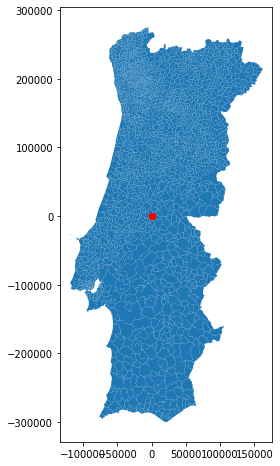

In [39]:
ax = parishes.plot(figsize=(15,8))
geo_res_green_areas.plot(color='r', ax=ax)